# Evaluating Preference Independence using Regression Trees


## The Motivation

Just to make sure we're on the same page, I'd like to start by trying to summarize our motivating question. 

From prior analysis, we have reason to believe that the causal impact of different conditions in a conjoint experiment on support for business development investment may not be independent. In particular, there is evidence that when one varies the potential economic returns to the investment, one sees very different patterns in the causal effects of different information treatments related to the environmental impact of these projects. 

To illustrate, consider the following two plots. In the first, we show how the causal effect of different job-creation treatments does not vary with environmental certification treatments:

![no_dependency](40_docs/images/no_dependency.png)![legend](40_docs/images/legend.png)

As the figure shows, regardess of whether the investment is pursuing or has received environmental certification, the marginal impact of moving from 100 jobs to 1000 jobs is constant, and the marginal impact of moving from 1,000 to 100,000 jobs is roughly constant. 

My contrast, if we look at the marginal effect of different waste treatment conditions, the marginal effects vary radically. 

![dependent_prefs](40_docs/images/dependent_prefs.png)![legend](40_docs/images/legend.png)

If waste is low (100HH), then moving from 100 jobs to 1,000 jobs has about the same marginal effect as moving from 1,000 to 10,000. If, by contrast, there is waste 300HH of waste, then the marginal effect of moving from 100 to 1,000 jobs is large, but there's no effect of moving from 1,000 to 10,000. And if there is 1,000 HH of waste, then moving from 100 to 1,000 jobs has no effect, but moving from 1,000 to 10,000 jobs has a large effect. 

This is pretty clear evidence of interdependence of effects. 

In addition (though this is not in the paper), this interdependence appears to be asymmetric: while the waste impact of a project impacts the effect of different job sizes, it is not clear the reverse is true (**right? Can't quite remember what slide you showed me!**)

## The Question

So we've established that we aren't working with fully independent preferences / the evaluation process subjects are using is not the process reflected in an additively seperable linear probability model. The question therefore is (a) what evaluation process *is* being used, and (b) how best can we statistically model that decision making process to make proper inferences about causal effects. 

### Lexicographic?

So I think the first question is whether evaluations are lexicographic (i.e. they don't weigh lots of different factors simultaneously, but rather sequentially and myopically, evaluating just one attribute first, then a second, etc.). 

The key aspect of lexicographic preferences is that the interdependence of preferences should be unidirectional: since the evaluation of the first attribute (call it A) comes before consideration of the next attribute (call it B), evaluations of A should be unaffected by the value of B, while the evaluations of B *may* be impacted by the value of A. 

Take the example of the marginal effects of Waste above -- there we see that the Waste conditions impact the causal effects of different job-size conditions. If we can also show that the marginal effect of moving from one Waste condition to another does *not* change as we vary job conditions, that would seem sufficient for showing that preferences are lexicographic. (I think this logic is correct, but please interrogate!)

Whether preferences are lexicographic is important because lexicographic preferences are implicit to regression trees. In a regression tree, binary splits of the data are created by sequentially prioritizing the cuts of the data that have the best (local) explanatory power. In the language of computer science, this is a *greedy* optimization: the fact that a regression tree algorithm splits first on whether an investment creates 100,000 jobs or not does not imply this will generate the best possible tree; it just means that among things you can split on first, that does the best job of explaining the data *immediately after the first split*. It is always possible we would have gotten better performance *overall* if we'd split on something different initially. 

As such, regression trees, I think, roughly embody a lexicographic evaluation that looks at the things that matter most first. So they are most valuable in a situation where we think that this properly models how people are making evaluations. 

Given that, I think a first step is testing for lexicographic perferences by looking for the kinds of asymmetries I describe above: for vignette features A and B, 

- is it the case that the marginal impact of moving from treatment 1 of A to treatment 2 of A varies as we vary B, and 
- is it also the case that the marginal impact of moving from treatment 1 of B to treatment 2 of B does NOT vary as we vary A. 

(I think this is identified? But if not, we can compare how (a) the move from treatment 1 to treatment 2 to the move from treatment 2 to treatment 3 varies as (b) we vary B.)

### They're Just Not Independent

The other possibility, I think, is that evaluations can still be modeled as being additively seperable (i.e. they're being evaluated simultaneously), they're just not independent. 

In that case, I think the easiest approach to evaluating things would just be to run a linear regression model with interactions. I know that's not particularly sexy, but I think that'd pull out all the information we want, and come with the benefit of being easily interpretable (or as easy as indicators ever are), and it come with standard errors, which don't fall out of regression trees. 

# Let's do some regression trees!

While we're thinking about these questions, I think it makes sense to just run some regression trees to also make all this more concrete. So here's a set of regression trees (a CART model from `scikit-learn`) for predicting choice. 

(Also: in the end I decided this use-case was too weird for students, so I didn't end up making an exercise from this... So it won't look exercise-like at all). 

Also an important caveat since we're working together for the first time: This code is new, and I don't ever stand by my code until I've had time to walk away from it and review it at least once. So this is all super preliminary, and may have bugs I can't see yet!

The goal here is twofold: 

1. I'm curious what loads in a regression tree
2. Give use concrete examples of what output looks like so we can think about the value of having these to share. 

But let me emphasize the following: these trees are ordered soley on the basis of best prediction. If we wanted to do this in a theoretically motivated way, we'd want to order our tree based on what evaluations appear to come before others in our analysis of whether preferences are lexicographic (something that will also require some hand-coding, since regression tree packages don't allow for specification of tree order). 

## Load and Clean Data

In [1]:
import os 
import pandas as pd
os.chdir('/users/nick/github/preference_interdependence')
df = pd.read_stata('00_source_data/Fish_VN2018_rep.dta')

In [2]:
df.head()

,tinh,choice,papi_sector,origin,ownership,sector,employment,taxrevenue,localsourcing,greenviolation,...,FDINumberOfProjects,FDITotalInvCapital,provincdum,airqual,waterqual,envrisk,pmlevel,investcapt,business,projects
0,Ha Noi,0.0,1.0,Vietnamese firm,Private,Electronics,"10,000 jobs",2 BVND,2 BVND,Damage to 1000HHs,...,4489,27288.70316,1.0,Bad,0.0,0.0,1.0,1.0,1.0,1.0
1,Ha Noi,0.0,3.0,Developed FIE,SOE,Mining,100 jobs,200 BVND,20 BVND,Damage to 100HHs,...,4489,27288.70316,1.0,Good,NaN,0.0,1.0,1.0,1.0,1.0
2,Ha Noi,1.0,1.0,Developed FIE,SOE,Electronics,1000 jobs,2 BVND,200 BVND,Damage to 1000HHs,...,4489,27288.70316,1.0,Bad,0.0,0.0,1.0,1.0,1.0,1.0
3,Ha Noi,1.0,1.0,Developing FIE,SOE,Electronics,"10,000 jobs",20 BVND,2 BVND,No damage,...,4489,27288.70316,1.0,Bad,NaN,0.0,1.0,1.0,1.0,1.0
4,Ha Noi,0.0,1.0,Developing FIE,SOE,Electronics,1000 jobs,2 BVND,20 BVND,Damage to 1000HHs,...,4489,27288.70316,1.0,Good,NaN,0.0,1.0,1.0,1.0,1.0


In [3]:
# Just lookin' around...
df.sample(5).transpose()

,7472,15284,694,26791,22856
tinh,Vinh Phuc,Binh Dinh,Ha Noi,Can Tho,HCMC
choice,NaN,NaN,0,0,0
papi_sector,1,3,4,3,NaN
origin,Vietnamese firm,Vietnamese firm,Developing FIE,Developed FIE,Developing FIE
ownership,SOE,Private,Private,Private,Private
sector,Electronics,Vacation resort,Vacation resort,Electronics,Vacation resort
employment,1000 jobs,1000 jobs,100 jobs,100 jobs,100 jobs
taxrevenue,20 BVND,20 BVND,20 BVND,2 BVND,200 BVND
localsourcing,2 BVND,200 BVND,200 BVND,200 BVND,20 BVND
greenviolation,Damage to 100HHs,Damage to 1000HHs,No damage,Damage to 100HHs,No damage


In [4]:
# Subset to core treatments
df = df[df.columns[3:12].to_list() + ['choice']]

In [5]:
df.head()

,origin,ownership,sector,employment,taxrevenue,localsourcing,greenviolation,waste,greencertificate,choice
0,Vietnamese firm,Private,Electronics,"10,000 jobs",2 BVND,2 BVND,Damage to 1000HHs,1000HHs,Applying for certificate,0.0
1,Developed FIE,SOE,Mining,100 jobs,200 BVND,20 BVND,Damage to 100HHs,300HHs,Applying for certificate,0.0
2,Developed FIE,SOE,Electronics,1000 jobs,2 BVND,200 BVND,Damage to 1000HHs,100HHs,Using certificate,1.0
3,Developing FIE,SOE,Electronics,"10,000 jobs",20 BVND,2 BVND,No damage,1000HHs,Applying for certificate,1.0
4,Developing FIE,SOE,Electronics,1000 jobs,2 BVND,20 BVND,Damage to 1000HHs,1000HHs,No certificate,0.0


In [6]:
# Convert from a heterogeneous table to a homogenous array 
# (scikit-learn hates heterogeneous tables)

# Build formula for converting categoricals 
# to one-hot vectors
import patsy
formula = ''
for i in df.columns[:-1]:
    formula = formula + f'C({i}) + '
formula[:-2]

'C(origin) + C(ownership) + C(sector) + C(employment) + C(taxrevenue) + C(localsourcing) + C(greenviolation) + C(waste) + C(greencertificate) '

In [7]:
# Move categoricals to one-hot encodings (i.e. indicator variables)
df_y , df_X = patsy.dmatrices('choice ~ ' + formula[:-2], df, return_type='dataframe')

In [8]:
# Split the data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X.values, df_y.values, 
                                                    test_size=0.5, 
                                                    train_size=0.5,
                                                    random_state=41)

## Start fitting regression model

In [9]:
from sklearn import tree
import numpy as np
import graphviz

### First, let's limit the tree to 3 levels for readability.

So here's a regression tree limited to three levels. I left in the original variable labels (it's a lot of work to make them extra readable), so the boxes below are read as follows:

1. The top line is the variable. So in the top cell below, `C(greenviolation)` is the categorical variable we're working with, and the specific dummy is the dummy for whether the investment caused "Damage to 1000HHs". The cutoff off is <=0.5 (the variable is 0,1, but the tree sees it as continuous), so the left branch (labeled "True") actually means that's the branch for when the project **didn't** damage 1000HHs.
2. `gini` is describes the gini for outcomes in the budget, which for a binary outcome is just the heterogeneity in outcomes. We start with Gini of 0.5 in the top box (half chosen, by construction). Lower gini means better a more homogenous bucket. So gini = 0 means we have a bucket that's all "chosen" or "not chosen". We want lower gini. 
3. `samples` is number of observations in this bucket before the split. 
4. `Value` is number of observations with `choice=0` (first entry) and number of observations with `choice=1` (right entry). 

Right above each graph, you will also see me plot the accuracy of the tree (the share of predictions of the tree that match actual values of `choice` in test data (the half of our data we didn't use to train the model)). 

Model accuracy (share of classification correct on test data: 0.62


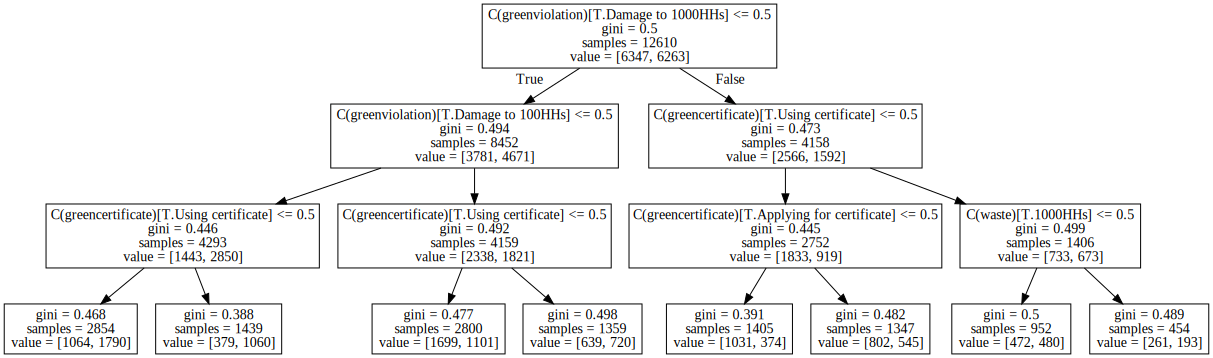

In [10]:
my_model = tree.DecisionTreeClassifier(max_depth=3)
my_model.fit(X_train, y_train)

# Evaluate
print(f'Model accuracy (share of classification correct on test data: {my_model.score(X_test, y_test):.2f}')

# Visualize
dot_data = tree.export_graphviz(my_model, out_file=None, 
                                feature_names=df_X.columns.tolist())
graph = graphviz.Source(dot_data)  
graph 

### Now we can fit it to 4 Levels

Model accuracy (share of classification correct on test data: 0.63


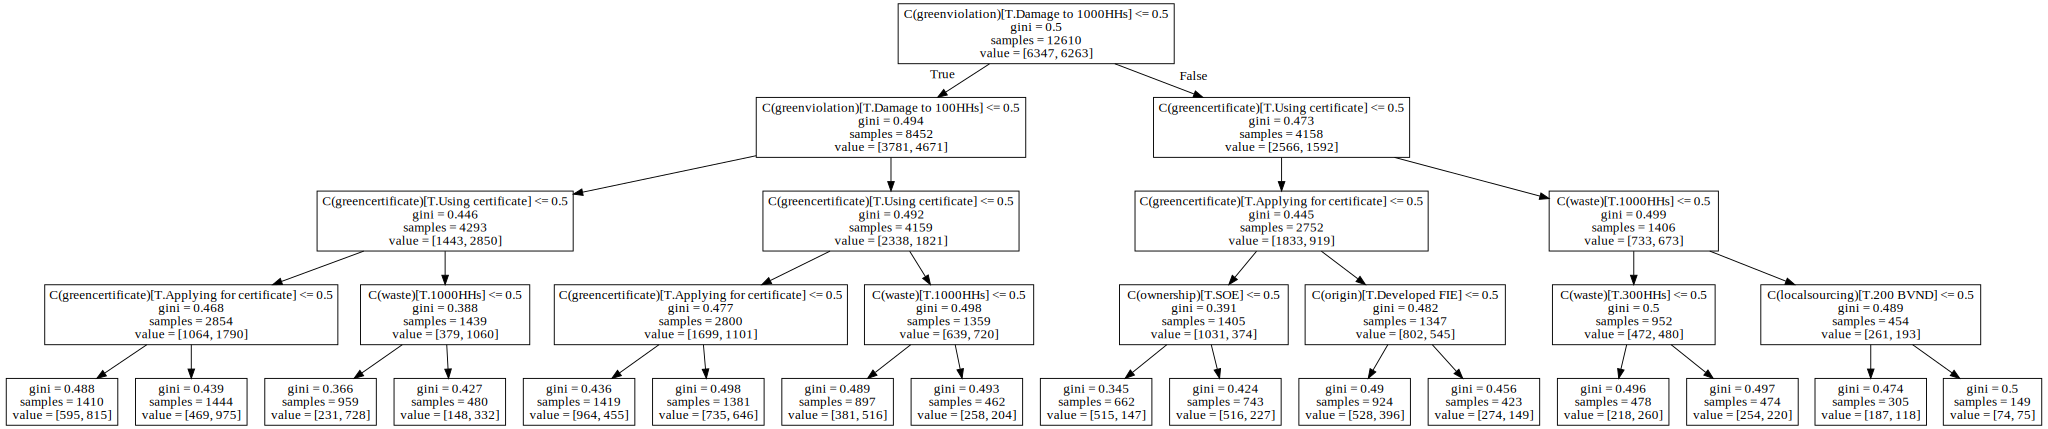

In [11]:
my_model = tree.DecisionTreeClassifier(max_depth=4)
my_model.fit(X_train, y_train)

# Evaluate
print(f'Model accuracy (share of classification correct on test data: {my_model.score(X_test, y_test):.2f}')

# Visualize
dot_data = tree.export_graphviz(my_model, out_file=None, 
                                feature_names=df_X.columns.tolist())
graph = graphviz.Source(dot_data)  
graph 

### And if you want to see of arbitrary depth...

We can see how performance varies as we vary depth.

In [13]:
for depth in range(2, 12):
    my_model = tree.DecisionTreeClassifier(max_depth = depth)
    my_model.fit(X_train, y_train)

    # Evaluate
    print(f'Model accuracy for depth {depth}: (share of classification correct on test data): {my_model.score(X_test, y_test):.3f}')

Model accuracy for depth 2: (share of classification correct on test data): 0.621
Model accuracy for depth 3: (share of classification correct on test data): 0.624
Model accuracy for depth 4: (share of classification correct on test data): 0.628
Model accuracy for depth 5: (share of classification correct on test data): 0.625
Model accuracy for depth 6: (share of classification correct on test data): 0.624
Model accuracy for depth 7: (share of classification correct on test data): 0.616
Model accuracy for depth 8: (share of classification correct on test data): 0.614
Model accuracy for depth 9: (share of classification correct on test data): 0.605
Model accuracy for depth 10: (share of classification correct on test data): 0.596
Model accuracy for depth 11: (share of classification correct on test data): 0.581


OK, so looks like the optimal tree depth is actually 4. So that means that if we didn't do a lot of manual tree manipulations, your favorite variable (number of jobs created) actually wouldn't come into play at all!